https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json, requests

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
def download_file(url, save_directory="./data"):
    os.makedirs(save_directory, exist_ok=True)
    filename = os.path.join(save_directory, url.split("/")[-1].split("?")[0])
    response = requests.get(url, stream=True)
    response.raise_for_status()
    with open(filename, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

Here we download the image, convert to PyTorch tensor, and apply preprocessing transformations.

In [3]:
dog_image_url = "https://github.com/marcotcr/lime/blob/master/doc/notebooks/data/dogs.png?raw=true"
imagenet_json_url = "https://raw.githubusercontent.com/marcotcr/lime/refs/heads/master/doc/notebooks/data/imagenet_class_index.json"
download_file(dog_image_url)
download_file(imagenet_json_url)

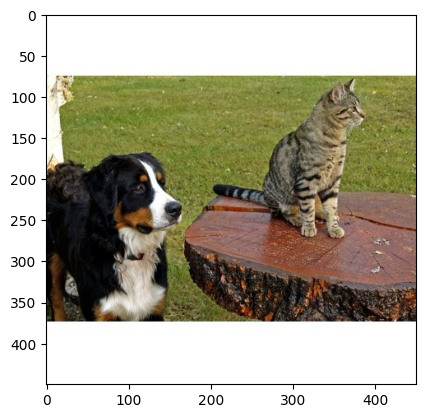

In [4]:
def get_image(path):
    with open(os.path.abspath(path), "rb") as f:
        with Image.open(f) as img:
            return img.convert("RGB")


img = get_image("./data/dogs.png")
plt.imshow(img)

In [5]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
    transf = transforms.Compose(
        [
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ]
    )

    return transf


def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

Here we load a pre-trained model from PyTorch.

In [6]:
model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)

Next we load the key for imagenet classes.

In [7]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(
    os.path.abspath("./data/imagenet_class_index.json"), "r"
) as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {
        class_idx[str(k)][0]: class_idx[str(k)][1]
        for k in range(len(class_idx))
    }
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

Now we get a prediction to inspect.

In [8]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

LIME requires probabilities but our network returns logits by default. Passing the logits through softmax enables getting probabilities for the top 5 predictions.

In [9]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple(
    (p, c, idx2label[c])
    for p, c in zip(
        probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()
    )
)

((np.float32(0.93593013), np.int64(239), 'Bernese_mountain_dog'),
 (np.float32(0.03844793), np.int64(241), 'EntleBucher'),
 (np.float32(0.023756264), np.int64(240), 'Appenzeller'),
 (np.float32(0.0018181766), np.int64(238), 'Greater_Swiss_Mountain_dog'),
 (np.float32(9.113325e-06), np.int64(214), 'Gordon_setter'))

We are getting ready to use Lime. Lime produces the array of images from original input image by pertubation algorithm. So we need to provide two things: (1) original image as numpy array (2) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output.

For Pytorch, first we need to define two separate transforms: (1) to take PIL image, resize and crop it (2) take resized, cropped image and apply whitening.

In [10]:
def get_pil_transform():
    transf = transforms.Compose(
        [transforms.Resize((256, 256)), transforms.CenterCrop(224)]
    )

    return transf


def get_preprocess_transform():
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
    transf = transforms.Compose([transforms.ToTensor(), normalize])

    return transf


pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

Now we are ready to define classification function that Lime needs. The input to this function is numpy array of images where each image is ndarray of shape (channel, height, width). The output is numpy aaray of shape (image index, classes) where each value in array should be probability for that image, class combination.

In [11]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Now we can test our function on a sample image.

In [12]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

np.int64(239)

Now we are ready to use LIME!

In [13]:
from lime import lime_image

In [14]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    np.array(pill_transf(img)),
    batch_predict,  # classification function
    top_labels=5,
    hide_color=0,
    num_samples=1000,
)  # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
from skimage.segmentation import mark_boundaries

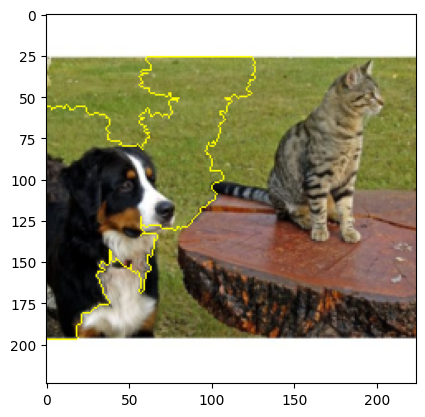

In [16]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False,
)
img_boundry1 = mark_boundaries(temp / 255.0, mask)
plt.imshow(img_boundry1)

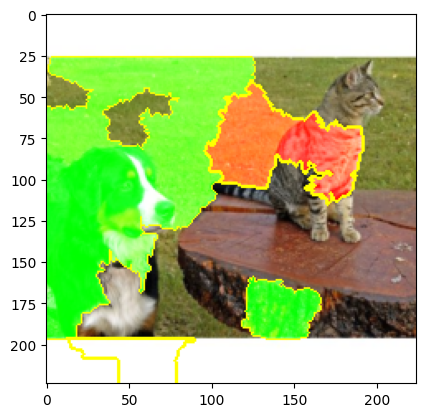

In [19]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=10,
    hide_rest=False,
)
img_boundry2 = mark_boundaries(temp / 255.0, mask)
plt.imshow(img_boundry2)